In [1]:
!pip install numpy

In [2]:
!pip install scikit-learn

In [3]:
!pip install tensorflow

In [4]:
!pip install Pillow

In [6]:
!pip install opencv-python

In [5]:
import tensorflow as tf

print("Is Built with CUDA: ", tf.test.is_built_with_cuda())

Is Built with CUDA:  True


In [13]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  4


In [8]:
print(tf.__version__)

2.14.0


In [9]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]


In [1]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from PIL import Image
import os

def load_images_and_masks(image_dir, mask_dir, limit=10):
    image_paths = sorted([
        os.path.join(image_dir, fname)
        for fname in os.listdir(image_dir)
        if fname.endswith('.png') and fname.startswith("x")
    ])[:limit]

    mask_paths = sorted([
        os.path.join(mask_dir, fname)
        for fname in os.listdir(mask_dir)
        if fname.endswith('.png') and fname.startswith("y")
    ])[:limit]

    images = [np.array(Image.open(path).convert("L")) / 255.0 for path in image_paths]
    images = [image.reshape(512, 512, 1) for image in images]
    masks = [np.array(Image.open(path).convert("L")) for path in mask_paths]

    for i, mask in enumerate(masks):
        masks[i][mask == 127] = 1  # Class 1
        masks[i][mask == 255] = 2  # Class 2
        masks[i] = to_categorical(masks[i], num_classes=3)

    return np.array(images), np.array(masks)

X, Y = load_images_and_masks("x", "y", 1032)

In [2]:
X.shape

(1032, 512, 512, 1)

In [3]:
Y.shape

(1032, 512, 512, 3)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [5]:
print(X.shape)
print(f"Train size: {X_train.shape}, {y_train.shape}")
print(f"Val size: {X_val.shape}, {y_val.shape}")

(1032, 512, 512, 1)
Train size: (825, 512, 512, 1), (825, 512, 512, 3)
Val size: (103, 512, 512, 1), (103, 512, 512, 3)


In [14]:
from tensorflow.keras.layers import Input, Conv2D, concatenate, Dropout, MaxPooling2D, UpSampling2D, PReLU
from tensorflow.keras.models import Model

def parallel_net_segmentation(input_size=(512, 512, 1), num_classes=3):
    inputs = Input(input_size)

    # First parallel block
    path_a1 = Conv2D(64, (3, 3), padding='same')(inputs)
    path_a1 = PReLU()(path_a1)
    path_b1 = Conv2D(64, (5, 5), padding='same')(inputs)
    path_b1 = PReLU()(path_b1)
    merged1 = concatenate([path_a1, path_b1], axis=3)
    pool1 = MaxPooling2D(pool_size=(2, 2))(merged1)

    # Second parallel block
    path_a2 = Conv2D(128, (3, 3), padding='same')(pool1)
    path_a2 = PReLU()(path_a2)
    path_b2 = Conv2D(128, (5, 5), padding='same')(pool1)
    path_b2 = PReLU()(path_b2)
    merged2 = concatenate([path_a2, path_b2], axis=3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(merged2)

    # Third parallel block
    path_a3 = Conv2D(256, (3, 3), padding='same')(pool2)
    path_a3 = PReLU()(path_a3)
    path_b3 = Conv2D(256, (5, 5), padding='same')(pool2)
    path_b3 = PReLU()(path_b3)
    merged3 = concatenate([path_a3, path_b3], axis=3)
    drop3 = Dropout(0.65)(merged3)

    # Upsampling and skip connection 1
    upsample1 = UpSampling2D(size=(2, 2))(drop3)
    skip1 = concatenate([upsample1, merged2], axis=3)

    # Fourth parallel block with skip connection
    path_a4 = Conv2D(128, (3, 3), padding='same')(skip1)
    path_a4 = PReLU()(path_a4)
    path_b4 = Conv2D(128, (5, 5), padding='same')(skip1)
    path_b4 = PReLU()(path_b4)
    merged4 = concatenate([path_a4, path_b4], axis=3)

    # Upsampling and skip connection 2
    upsample2 = UpSampling2D(size=(2, 2))(merged4)
    skip2 = concatenate([upsample2, merged1], axis=3)

    # Fifth parallel block with skip connection
    path_a5 = Conv2D(64, (3, 3), padding='same')(skip2)
    path_a5 = PReLU()(path_a5)
    path_b5 = Conv2D(64, (5, 5), padding='same')(skip2)
    path_b5 = PReLU()(path_b5)
    merged5 = concatenate([path_a5, path_b5], axis=3)

    # Final convolutional layer for segmentation
    output = Conv2D(num_classes, (1, 1), activation='softmax')(merged5)

    model = Model(inputs=inputs, outputs=output)

    return model


In [15]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.metrics import Recall, Precision, MeanIoU
from tensorflow.keras.losses import categorical_crossentropy


smooth = 1e-6  # To avoid division by zero
def dice_coefficient(y_true, y_pred):
    smooth = 1e-6  # To avoid division by zero
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = tf.keras.backend.sum(tf.keras.backend.abs(y_true * y_pred), axis=-1)
    sum_ = tf.keras.backend.sum(tf.keras.backend.abs(y_true) + tf.keras.backend.abs(y_pred), axis=-1)
    iou = (intersection + smooth) / (sum_ - intersection + smooth)
    return iou

def combined_dice_crossentropy_loss(y_true, y_pred, dice_loss_weight=0.5):
    # Dice Loss
    dice_loss_value = dice_loss(y_true, y_pred)

    # Categorical Cross-Entropy Loss
    cross_entropy_loss_value = categorical_crossentropy(y_true, y_pred)

    # Combined Loss
    combined_loss = dice_loss_weight * dice_loss_value + (1 - dice_loss_weight) * cross_entropy_loss_value
    return combined_loss



strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

with strategy.scope():
    model = parallel_net_segmentation()
    optimizer = Adam(learning_rate=2e-4)  # Example learning rate
    model.compile(optimizer=optimizer, loss=combined_dice_crossentropy_loss, metrics=["accuracy", dice_coefficient, iou])

Number of devices: 4


In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
import datetime


log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Fit the model
callbacks = [
    ModelCheckpoint('model_best.h5', verbose=1, save_best_only=True),
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=0.00001, verbose=1),
    tensorboard_callback
]

results = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=4, epochs=200,
    callbacks=callbacks
)

Epoch 1/200
207/207 [==============================] - ETA: 0s - loss: 0.3624 - accuracy: 0.8005 - dice_coefficient: 0.7440 - iou: 0.6799
Epoch 1: val_loss improved from inf to 0.33189, saving model to model_best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


207/207 [==============================] - 158s 603ms/step - loss: 0.3624 - accuracy: 0.8005 - dice_coefficient: 0.7440 - iou: 0.6799 - val_loss: 0.3319 - val_accuracy: 0.8137 - val_dice_coefficient: 0.7612 - val_iou: 0.6945 - lr: 2.0000e-04
Epoch 2/200
207/207 [==============================] - ETA: 0s - loss: 0.2837 - accuracy: 0.8358 - dice_coefficient: 0.7994 - iou: 0.7439
Epoch 2: val_loss improved from 0.33189 to 0.27712, saving model to model_best.h5
207/207 [==============================] - 122s 587ms/step - loss: 0.2837 - accuracy: 0.8358 - dice_coefficient: 0.7994 - iou: 0.7439 - val_loss: 0.2771 - val_accuracy: 0.8343 - val_dice_coefficient: 0.8070 - val_iou: 0.7513 - lr: 2.0000e-04
Epoch 3/200
207/207 [==============================] - ETA: 0s - loss: 0.2320 - accuracy: 0.8762 - dice_coefficient: 0.8389 - iou: 0.7920
Epoch 3: val_loss improved from 0.27712 to 0.23654, saving model to model_best.h5
207/207 [==============================] - 122s 589ms/step - loss: 0.2320 - 

In [17]:
# Evaluate the model on the test set
test_loss, test_accuracy, d, i = model.evaluate(X_test, y_test, verbose=1)

# Print out the performance metrics
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Dice Co-efficient: {d}")
print(f"Test iou: {i}")

4/4 [==============================] - 18s 5s/step - loss: 0.0913 - accuracy: 0.9619 - dice_coefficient: 0.9580 - iou: 0.9476
Test Loss: 0.09126036614179611
Test Accuracy: 0.9618979096412659
Test Dice Co-efficient: 0.9579805731773376
Test iou: 0.9476110935211182


# **Split**

In [18]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.metrics import Recall, Precision, MeanIoU
from tensorflow.keras.losses import categorical_crossentropy


smooth = 1e-6  # To avoid division by zero
def dice_coefficient(y_true, y_pred):
    smooth = 1e-6  # To avoid division by zero
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = tf.keras.backend.sum(tf.keras.backend.abs(y_true * y_pred), axis=-1)
    sum_ = tf.keras.backend.sum(tf.keras.backend.abs(y_true) + tf.keras.backend.abs(y_pred), axis=-1)
    iou = (intersection + smooth) / (sum_ - intersection + smooth)
    return iou

def combined_dice_crossentropy_loss(y_true, y_pred, dice_loss_weight=0.5):
    # Dice Loss
    dice_loss_value = dice_loss(y_true, y_pred)

    # Categorical Cross-Entropy Loss
    cross_entropy_loss_value = categorical_crossentropy(y_true, y_pred)

    # Combined Loss
    combined_loss = dice_loss_weight * dice_loss_value + (1 - dice_loss_weight) * cross_entropy_loss_value
    return combined_loss

In [19]:
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image
import cv2


def get_input_array(image_path):
  array = np.array(Image.open(image_path).convert("L").resize((512, 512), Image.LANCZOS))
  array = array.reshape(512, 512, 1)
  array = array / 255
  array = np.expand_dims(array, axis = 0) # Adding batch.
  return array

def get_probability_distro(input_array):
  model_path = 'model_best.h5'
  x = {
      "combined_dice_crossentropy_loss": combined_dice_crossentropy_loss,
      "iou": iou,
      "dice_coefficient": dice_coefficient
  }
  model = load_model(model_path, custom_objects=x)
  predictions = model.predict(input_array)

  probability_distro = predictions[0]
  return probability_distro

def get_segmentation(probability_distro):
  return np.argmax(probability_distro, axis = -1)

def get_rgb_image(segmentation):
  rgb_image = np.zeros((*segmentation.shape, 3), dtype=np.uint8)

  colors = {
      0: [0, 0, 0], # Black - BG
      1: [127, 127, 127], # Grey - VAT
      2: [255, 255, 255] # White - SAT
  }

  for class_index, color in colors.items():
    rgb_image[segmentation == class_index] = color

  return rgb_image

def get_grayscale_image(segmentation):
    grayscale_image = np.zeros(segmentation.shape, dtype=np.uint8)

    intensities = {
        0: 0,   # Black - BACKGROUND
        1: 127, # Grey - VISCERAL_FAT
        2: 255  # White - SUPERFICIAL_FAT
    }

    for class_index, intensity in intensities.items():
        grayscale_image[segmentation == class_index] = intensity

    return grayscale_image

import matplotlib.pyplot as plt

def clean_gray_scale_image(gray_scale_image):
    """
    This function converts only the white pixels within the interior of the ring to grey,
    while preserving the white border and existing grey areas.
    """
    # Define class values
    BACKGROUND = 0  # Black
    VISCERAL_FAT = 127  # Grey
    SUPERFICIAL_FAT = 255  # White

    # Step 1: Create a mask for the white (superficial fat) areas
    white_mask = gray_scale_image == SUPERFICIAL_FAT

    # Initialize a mask that will be used to fill contours
    mask = np.zeros_like(gray_scale_image, dtype=np.uint8)

    # Step 2: Find all contours on the white mask
    contours, hierarchy = cv2.findContours(white_mask.astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

    # Step 3: Fill the white areas that are not border (i.e., have a parent contour which is the border)
    for i, contour in enumerate(contours):
        # Check if the contour has a parent contour
        if hierarchy[0, i, 3] != -1:  # Has a parent contour
            cv2.drawContours(mask, [contour], -1, 1, -1)

    # Update segmentation image: convert the white to grey where mask is 1 and original pixel is not BACKGROUND
    gray_scale_image = np.where((mask == 1) & (gray_scale_image != BACKGROUND), VISCERAL_FAT, gray_scale_image)

    return gray_scale_image

In [20]:
input_array = get_input_array("x/x_1.png")
probability_distro = get_probability_distro(input_array)
segmentation = get_segmentation(probability_distro)

1/1 [==============================] - 0s 268ms/step


In [21]:
gray_scale_image = get_grayscale_image(segmentation)
final_image = clean_gray_scale_image(gray_scale_image.copy())

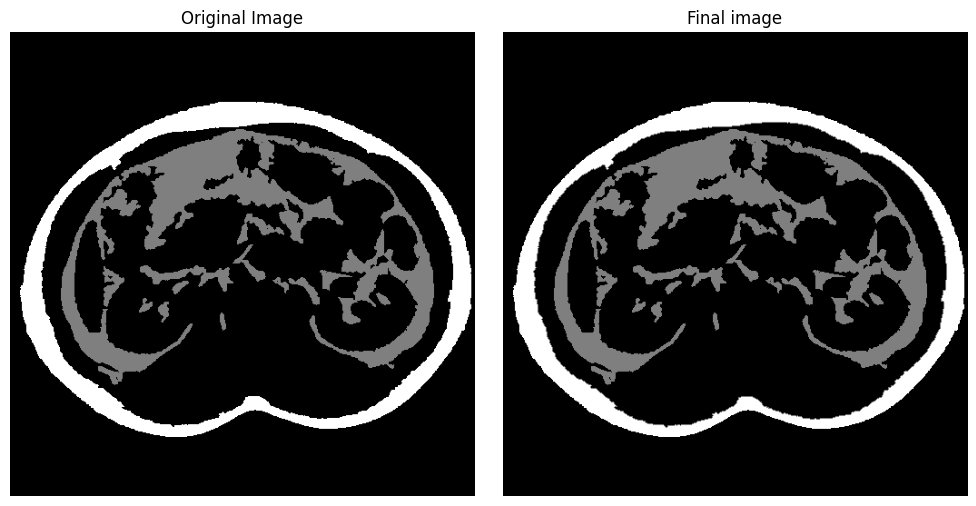

In [22]:
# Display the original and converted images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(gray_scale_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Final image')
plt.imshow(final_image, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# def convert_interior_white_to_grey(segmentation):
#     """
#     This function converts only the white pixels within the interior of the ring to grey,
#     while preserving the white border and existing grey areas.
#     """
#     # Define class values
#     BACKGROUND = 0  # Black
#     VISCERAL_FAT = 128  # Grey
#     SUPERFICIAL_FAT = 255  # White

#     # Step 1: Create a mask for the white (superficial fat) areas
#     white_mask = segmentation == 0

#     # Step 2: Find all contours on the white mask
#     contours, hierarchy = cv2.findContours(white_mask.astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

#     # Step 3: Fill the white areas that are not border (i.e., have a parent contour which is the border)
#     for i, contour in enumerate(contours):
#         # Check if the contour has a parent contour
#         if hierarchy[0, i, 3] != -1:  # Has a parent contour
#             cv2.drawContours(segmentation, [contour], -1, VISCERAL_FAT, -1)

#     return segmentation

# image = np.array(Image.open("a.png").convert("L"))
# # Apply the conversion function to the original segmentation
# converted_interior_segmentation = convert_interior_white_to_grey(image.copy())

# # Display the original and converted images
# plt.figure(figsize=(10, 5))

# plt.subplot(1, 2, 1)
# plt.title('Original Image')
# plt.imshow(image, cmap='gray')
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.title('Converted Interior Segmentation')
# plt.imshow(converted_interior_segmentation, cmap='gray')
# plt.axis('off')

# plt.tight_layout()
# plt.show()


In [23]:
!zip -r /content/file.zip /content/logs/

  adding: content/logs/ (stored 0%)
  adding: content/logs/fit/ (stored 0%)
  adding: content/logs/fit/20231213-201857/ (stored 0%)
  adding: content/logs/fit/20231213-201857/train/ (stored 0%)
  adding: content/logs/fit/20231213-201857/train/events.out.tfevents.1702498745.fde8f4951a83.70284.3.v2 (deflated 79%)
  adding: content/logs/fit/20231213-201857/validation/ (stored 0%)
  adding: content/logs/fit/20231213-201857/validation/events.out.tfevents.1702498881.fde8f4951a83.70284.4.v2 (deflated 79%)


In [24]:
from google.colab import files
files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>